In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 𝜆 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。<br>

$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$

ここで 𝑘(𝑥𝑖,𝑥𝑗) はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。<br>

$k(x_i, x_j) = x_{i}^{T} x_j$

条件として、更新毎に 𝜆𝑖>=0を満たす必要があります。満たさない場合は 𝜆𝑖=0とします。


𝑖,𝑗 : サンプルのインデックス<br>
𝜆𝑛𝑒𝑤𝑖 : 更新後のi番目のサンプルのラグランジュ乗数<br>
𝜆𝑖 : 更新前のi番目のサンプルのラグランジュ乗数<br>
𝛼 : 学習率<br>
𝜆𝑗 : j番目のサンプルのラグランジュ乗数<br>
𝑦𝑖 : i番目のサンプルのラベル<br>
𝑦𝑗 : j番目のサンプルのラベル<br>
𝑥𝑖 : i番目のサンプルの特徴量ベクトル<br>
𝑥𝑗 : j番目のサンプルの特徴量ベクトル<br>


あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

# 【問題2】サポートベクターの決定
計算したラグランジュ乗数 𝜆 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。<br>


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。<br>



# 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 𝑓(𝑥) の符号が分類結果です。<br>

$f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)$

𝑥 : 推定したいデータの特徴量ベクトル<br>
𝑁 : サポートベクターの数<br>
𝑛 : サポートベクターのインデックス<br>
𝜆𝑛 : 𝑛番目のサポートベクターのラグランジュ乗数<br>
𝑦𝑠𝑣𝑛 : 𝑛番目のサポートベクターのラベル<br>
𝑘() : カーネル関数<br>
𝑠𝑛 : 𝑛番目のサポートベクターの特徴量<br>

# 【問題】１〜３の回答をScratchSVMClassifierクラスに実装

In [2]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False, gamma=None, theta=None, d=None):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta = theta
        self.d = d
        #学習過程（サポートベクターの数）を記録する配列を用意
        self.svloss = np.zeros(self.iter)
        self.val_svloss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        #訓練データの学習処理
        lug_up_list = [np.random.random((X.shape[0], 1))] #更新されたlugを格納するリスト
        for i in range(self.iter):
            k = self.kernel_function(X) #カーネル関数
            lug_update = self.lug_gradient_ascent(y, lug_up_list[-1], k) #ラグランジュ乗数λ = lug を更新
            lug_up_list.append(lug_update) #更新されたlugをリストへ格納
            self.svloss[i] = len(np.where(lug_up_list[-1] > self.threshold)[0]) #サポートベクターの数の記録 
       
        #verboseをTrueにした際は学習過程（サポートベクターの数）を出力する
        if self.verbose:
            print("訓練データの学習過程（サポートベクター数）：{}".format(self.svloss)) 
        
        #学習済みのラグランジュ乗数λ = lug
        self.lug = lug_up_list[-1]
        #学習過程全てのラグランジュ乗数λ = lug
        self.lug_k = lug_up_list
        
        #サポートベクターの決定(【問題２】を関数化) 
        self.support_vector_determining(X, y)
        
        #検証データの学習処理
        if X_val is None and y_val is None:
            pass
        else:
            val_lug_up_list = [np.random.random((X_val.shape[0], 1))] #更新されたlugを格納するリスト
            for i in range(self.iter):
                val_k = self.kernel_function(X_val) #カーネル関数
                val_lug_update = self.lug_gradient_ascent(y_val, val_lug_up_list[-1], val_k) #ラグランジュ乗数λ = val_lug を更新
                val_lug_up_list.append(val_lug_update) #更新されたlugをリストへ格納
                self.val_svloss[i] = len(np.where(val_lug_up_list[-1] > self.threshold)[0]) #サポートベクターの数の記録 

            #verboseをTrueにした際は学習過程（サポートベクターの数）を出力する
            if self.verbose:
                print("検証データの学習過程（サポートベクター数）：{}".format(self.val_svloss)) 
    
    #サポートベクターの決定(【問題２】を関数化)
    def support_vector_determining(self, X, y):
        #サポートベクターのインデックス
        self.index_support_vectors = np.where(self.lug > self.threshold)[0]
        #サポートベクターの数
        self.n_support_vectors = len(self.index_support_vectors)
        #サポートベクターの特徴量
        self.X_sv = X[self.index_support_vectors]
        #サポートベクターの未定乗数
        self.lam_sv = self.lug[self.index_support_vectors]
        #サポートベクターのラベル
        self.y_sv = y[self.index_support_vectors]       
    
    #【問題1】ラグランジュの未定乗数法による最急降下
    def lug_gradient_ascent(self, y, lug, k):
        y_k = y.reshape(-1, 1) @ y.reshape(-1, 1).T
        lug_pre = lug + self.lr * (1 - (y_k * k) @ lug) 
        lug_update = np.where((lug_pre < 0), 0, lug_pre)
    
        return lug_update
    
    #カーネル関数
    def kernel_function(self, X):
        
        if self.kernel == "linear":
            k = X @ X.T

        elif self.kernel == "polly":
            k = (self.gamma * (X @ X.T) + self.theta)**self.d
        
        else:
            pass
    
        return k
    
    #【問題３】　推定
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        hypo = self.lam_sv.flatten() * self.y_sv * (X @ self.X_sv.T)
        hypo_sum = np.sum(hypo, axis=1) #各列の合計
        pred = np.where((hypo_sum < 0), -1, 1)
        
        pass
        return pred

# 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。<br>

### シンプルデータセット1作成コード

In [3]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X_sim1 = X[random_index]
y_sim1 = y[random_index]

In [4]:
#シンプルデータセット1
X_data = X_sim1
y_data = y_sim1

# 訓練データと検証データの分割。訓練データ75%、検証データ25%として分割する。
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.75, random_state=123)
    
#標準化
scaler = StandardScaler()
scaler.fit(X_train) #訓練用のデータでfit
X_train_std = scaler.transform(X_train) #訓練用データをtransform
X_test_std = scaler.transform(X_test) #検証用データをtransform

In [5]:
#今回スクラッチしたモデル
svmc = ScratchSVMClassifier(num_iter=1000, lr=10**-3, kernel='linear', threshold=1e-5, verbose=False)
svmc.fit(X_train_std, y_train, X_test_std, y_test) #学習
y_pred = svmc.predict(X_test_std)#推定（クラス）
print(svmc.index_support_vectors)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=-1)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=-1)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=-1)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[ 13  19  20  28 102 130 167 176 301 338 365]
[-1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1  1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1
  1  1 -1 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1  1 -1 -1
  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1
 -1  1  1  1  1]
正解率：1.00
適合率：1.00
再現率：1.00
F値：1.00
混同行列：
[[62  0]
 [ 0 63]]
classification_report：
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        63

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [6]:
#SVC
svc = SVC(kernel='linear')
svc.fit(X_train_std, y_train) #学習
y_pred = svc.predict(X_test_std)#推定（クラス）
print(svc.support_)
# print(svc.support_vectors_)
# print(svc.n_support_)
# print(svc.dual_coef_)
# print(svc.coef_)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=-1)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=-1)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=-1)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[ 20 130 176  13  19]
[-1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1  1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1
  1  1 -1 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1  1 -1 -1
  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1
 -1  1  1  1  1]
正解率：1.00
適合率：1.00
再現率：1.00
F値：1.00
混同行列：
[[62  0]
 [ 0 63]]
classification_report：
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        63

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



## サポートベクターの数 等、細かい部分での挙動は異なるが、評価指標値はスクラッチとscikit-learnで同じ結果となった。

# 【問題5】決定領域の可視化
決定領域を可視化してください。<br>
以下の例のようにサポートベクターは異なる色で示してください。<br>

In [7]:
#2値分類用　グラフ化の関数（説明変数２個のみ対応）
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, X_sv, clf,  target_names, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel'):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = clf.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.scatter(X_sv[:, 0], X_sv[:, 1], s=80, color="yellow", label="sv", marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

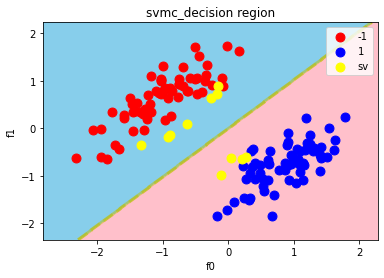

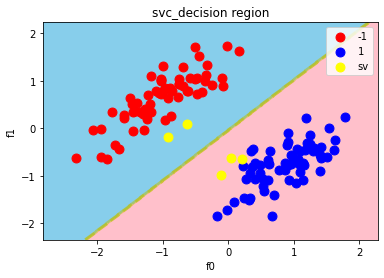

In [8]:
#svmc : 今回スクラッチしたモデル
decision_region(X_test_std, y_test, X_train_std[svmc.index_support_vectors], svmc, step=0.01, title='svmc_decision region', xlabel='f0', ylabel='f1', target_names=[-1, 1])

#svc : sklearnのモデル
decision_region(X_test_std, y_test, X_train_std[svc.support_], svc, step=0.01, title='svc_decision region', xlabel='f0', ylabel='f1', target_names=[-1, 1])

# 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。<br>

「線形カーネルの式」

$k(x_i, x_j) = x_{i}^{T} x_j$

「多項式カーネルの式」

$k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}$

$\gamma$, $\theta_0$, $d$ はハイパーパラメータです。<br>


線形カーネルは $\gamma = 1$, $\theta_0 = 0$, $d = 1$の場合の多項式カーネルと等しいと言えます。

In [9]:
#今回スクラッチしたモデル
svmp = ScratchSVMClassifier(num_iter=1000, lr=10**-3, kernel='polly', threshold=1e-5, verbose=True,  gamma=0.1, theta=1.0, d=2)
svmp.fit(X_train_std, y_train, X_test_std, y_test) #学習
y_pred = svmp.predict(X_test_std)#推定（クラス）
print(svmp.index_support_vectors)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=-1)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=-1)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=-1)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

訓練データの学習過程（サポートベクター数）：[356. 340. 325. 314. 307. 297. 279. 274. 260. 250. 243. 233. 227. 221.
 218. 212. 209. 205. 199. 191. 184. 179. 175. 173. 169. 167. 163. 157.
 156. 154. 152. 150. 147. 146. 143. 139. 137. 133. 132. 126. 126. 122.
 121. 121. 117. 116. 114. 113. 113. 113. 111. 111. 108. 107. 105. 104.
 103. 101. 101. 101. 101.  99.  98.  98.  98.  97.  96.  96.  96.  95.
  92.  92.  89.  88.  87.  87.  87.  86.  84.  84.  81.  81.  81.  81.
  81.  81.  79.  78.  78.  76.  76.  76.  75.  73.  72.  72.  72.  72.
  72.  72.  72.  72.  72.  72.  72.  72.  72.  71.  70.  70.  70.  69.
  69.  69.  68.  66.  63.  63.  63.  63.  62.  62.  62.  62.  61.  61.
  60.  60.  60.  59.  59.  58.  57.  57.  57.  57.  57.  58.  58.  58.
  58.  58.  58.  58.  58.  57.  57.  57.  56.  55.  55.  55.  55.  54.
  53.  53.  53.  53.  53.  53.  53.  53.  53.  53.  52.  52.  52.  52.
  52.  51.  51.  51.  51.  51.  50.  50.  50.  50.  50.  50.  50.  50.
  50.  50.  50.  49.  49.  49.  49.  49.  49.  49.  49.

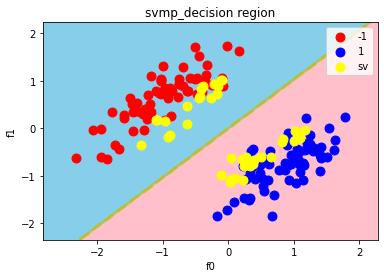

In [10]:
#svmp : 今回スクラッチしたモデル
decision_region(X_test_std, y_test, X_train_std[svmp.index_support_vectors], svmp, step=0.01, title='svmp_decision region', xlabel='f0', ylabel='f1', target_names=[-1, 1])

## 全体所感：なんとか実装は出来たものの、内容の詳細理解及び、ハイパーパラメータのチューニングまでは手が回らなかった。。今後理解を深めていく。